# Model Exploration

## Table of Contents
1. [Imports](#imports)
2. [Import_Data](#importData)
    1. [GVB_Data](#GVBData)
    2. [Amsterdam_Event_Data](#EventData)
    3. [Crowdedness_Data](#CrowdData)
3. [Data_Preperation](#DataPrep)
    1. [Combine_Datasets](#CombData)
    2. [Construct_Model_DataFrame](#testModel)
4. [Regression_Models](#regModels)
    1. [Split_Train_and_Test_Data](#trainTestSplit)
    2. [Baseline](#regBaseModel)
    3. [Random_Forrest_Regressor](#regRFGModel)
    4. [Gradient_Boosting_Regressor](#regGBRModel)
    5. [Lasso](#regABRModel)
5. [Classification_Models](#classification)
    1. [Numerical_Labels_to_Categorical_Labels](#classCatVar)
    2. [Split_Train_and Test_Data](#classTrainSplit)
    3. [Baseline](#classBaseModel)
    4. [Random_Forrest_Classifier](#classRFCModel)
    5. [Gradient_Boosting_Classification](#classGBCModel)
    6. [SGD](#classSGDModel)
    7. [Voting_Classification](#classVCModel)

## Imports <a name="imports"></a>

In [86]:
#Train/Test section
from sklearn.model_selection import train_test_split

#Regression Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LassoCV

#Regression Metrics
from sklearn.metrics import mean_squared_error

#Classification Models
from scipy.stats import norm
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier

#Classification Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

from yellowbrick.classifier import ClassPredictionError
from yellowbrick.regressor import PredictionError
from yellowbrick.features import Rank1D
from yellowbrick.features import Rank2D
from yellowbrick.features import RadViz

## Import Data <a name="importData"></a>

### GVB Data <a name="GVBData"></a>

In [2]:
#Full GVB Dataset
gvb_df = pd.read_csv("../../../Data_thesis/Full_Datasets/GVB.csv")

In [3]:
#Contents
gvb_df.head()

,Date,Hour,NieuwmarktCode,NieuwmarktLat,NieuwmarktLon,NieuwmarktArrivals,NieuwmarktDepartures,NieuwezijdsCode,NieuwezijdsLat,NieuwezijdsLon,...,DamLon,DamArrivals,DamDepartures,SpuiCode,SpuiLat,SpuiLon,SpuiArrivals,SpuiDepartures,weekday,is_weekend
0,2018-01-01,100,NMT,4.901239,52.371942,11.0,340.0,5069,4.893731,52.376288,...,52.373127,0.0,0.0,5062,4.889259,52.369097,0.0,0.0,0,0
1,2018-01-01,200,NMT,4.901239,52.371942,48.0,175.0,5069,4.893731,52.376288,...,52.373127,21.0,39.0,5062,4.889259,52.369097,0.0,0.0,0,0
2,2018-01-01,300,NMT,4.901239,52.371942,10.0,137.0,5069,4.893731,52.376288,...,52.373127,13.0,48.0,5062,4.889259,52.369097,0.0,0.0,0,0
3,2018-01-01,400,NMT,4.901239,52.371942,16.0,48.0,5069,4.893731,52.376288,...,52.373127,0.0,34.0,5062,4.889259,52.369097,0.0,0.0,0,0
4,2018-01-01,500,NMT,4.901239,52.371942,17.0,56.0,5069,4.893731,52.376288,...,52.373127,0.0,20.0,5062,4.889259,52.369097,0.0,0.0,0,0


### Amsterdam Event Data <a name="EventData"></a>

In [4]:
#Full Events Dataset
events_df = pd.read_csv("../../../Data_thesis/Full_Datasets/Events.csv")

In [5]:
events_df.head()

,Date,Event,Latitude,Longtitude
0,2018-04-20,Springsnow Festival,52.372638,4.894106
1,2018-05-20,Springsnow Festival,52.372638,4.894106
2,2018-05-20,Vurige Tongen,52.410332,4.749069
3,2018-05-21,Vurige Tongen,52.410332,4.749069
4,2018-06-03,Sneakerness,52.382834,4.920456


### Crowdedness Data <a name="CrowdData"></a>

In [6]:
#Full Crowdedness Dataset
crowd_df = pd.read_csv("../../../Data_thesis/Full_Datasets/Crowdedness.csv")

In [7]:
#Only select one camera --> GAWW-02
crowd_df = crowd_df[crowd_df["Sensor"] == "GAWW-02"]

In [8]:
crowd_df.head()

,Sensor,Date,Hour,SensorLongitude,SensorLatitude,CrowdednessCount
0,GAWW-02,2018-03-11,0,4.898903,52.373786,0
1,GAWW-02,2018-03-11,1,4.898903,52.373786,0
2,GAWW-02,2018-03-11,10,4.898903,52.373786,0
3,GAWW-02,2018-03-15,4,4.898903,52.373786,39
4,GAWW-02,2018-04-21,17,4.898903,52.373786,1618


## Data Preperation <a name="DataPrep"></a>

### Combine datasets <a name="CombData"></a>

In [9]:
df = pd.merge(gvb_df, crowd_df, on=["Date", "Hour"])

In [10]:
full = pd.merge(events_df, df, on=["Date"], how="outer")
full = full.rename(index=str, columns={"Latitude": "event_lat", "Longtitude": "event_lon", "Event": "is_event"})
full = full.fillna(0.0)

In [11]:
full_dict = full.to_dict("index")

In [12]:
for k, v in full_dict.items():
    if v["is_event"] != 0.0:
        v["is_event"] = 1.0

In [13]:
full = pd.DataFrame.from_dict(full_dict, orient="index")

In [14]:
full.head()

,Date,is_event,event_lat,event_lon,Hour,NieuwmarktCode,NieuwmarktLat,NieuwmarktLon,NieuwmarktArrivals,NieuwmarktDepartures,...,SpuiLat,SpuiLon,SpuiArrivals,SpuiDepartures,weekday,is_weekend,Sensor,SensorLongitude,SensorLatitude,CrowdednessCount
0,2018-04-20,1.0,52.372638,4.894106,0.0,NMT,4.901239,52.371942,44.0,143.0,...,4.889259,52.369097,13.0,40.0,4.0,0.0,GAWW-02,4.898903,52.373786,0.0
1,2018-04-20,1.0,52.372638,4.894106,0.0,NMT,4.901239,52.371942,44.0,143.0,...,4.889259,52.369097,13.0,40.0,4.0,0.0,GAWW-02,4.898903,52.373786,747.0
10,2018-05-20,1.0,52.358560,4.897830,0.0,NMT,4.901239,52.371942,83.0,225.0,...,4.889259,52.369097,0.0,70.0,6.0,1.0,GAWW-02,4.898903,52.373786,2263.0
100,2018-06-02,1.0,52.372638,4.894106,0.0,NMT,4.901239,52.371942,42.0,67.0,...,4.889259,52.369097,0.0,0.0,5.0,1.0,GAWW-02,4.898903,52.373786,1565.0
1000,2018-08-20,0.0,0.000000,0.000000,0.0,NMT,4.901239,52.371942,43.0,124.0,...,4.889259,52.369097,0.0,0.0,0.0,0.0,GAWW-02,4.898903,52.373786,1017.0


### Construct Subset to train and test Model <a name="testModel"></a>

In [15]:
dates = full["Date"].values
np.random.shuffle(dates)

In [16]:
split = int(dates.size * 0.9)
train_set = dates[:split]
test_set = dates[split:]

In [72]:
train_df = full[full["Date"].isin(train_set)].drop(columns=["Date","NieuwmarktCode", 
                                                            "NieuwezijdsCode", "DamCode", "SpuiCode", "Sensor"])

test_df = full[full["Date"].isin(test_set)].drop(columns=["Date","NieuwmarktCode", 
                                                            "NieuwezijdsCode", "DamCode", "SpuiCode", "Sensor"])
full_df = full.drop(columns=["Date","NieuwmarktCode", 
                                                            "NieuwezijdsCode", "DamCode", "SpuiCode", "Sensor"])

In [18]:
train_df.head()

,is_event,event_lat,event_lon,Hour,NieuwmarktLat,NieuwmarktLon,NieuwmarktArrivals,NieuwmarktDepartures,NieuwezijdsLat,NieuwezijdsLon,...,DamDepartures,SpuiLat,SpuiLon,SpuiArrivals,SpuiDepartures,weekday,is_weekend,SensorLongitude,SensorLatitude,CrowdednessCount
0,1.0,52.372638,4.894106,0.0,4.901239,52.371942,44.0,143.0,4.893731,52.376288,...,312.0,4.889259,52.369097,13.0,40.0,4.0,0.0,4.898903,52.373786,0.0
1,1.0,52.372638,4.894106,0.0,4.901239,52.371942,44.0,143.0,4.893731,52.376288,...,312.0,4.889259,52.369097,13.0,40.0,4.0,0.0,4.898903,52.373786,747.0
10,1.0,52.358560,4.897830,0.0,4.901239,52.371942,83.0,225.0,4.893731,52.376288,...,456.0,4.889259,52.369097,0.0,70.0,6.0,1.0,4.898903,52.373786,2263.0
100,1.0,52.372638,4.894106,0.0,4.901239,52.371942,42.0,67.0,4.893731,52.376288,...,152.0,4.889259,52.369097,0.0,0.0,5.0,1.0,4.898903,52.373786,1565.0
1000,0.0,0.000000,0.000000,0.0,4.901239,52.371942,43.0,124.0,4.893731,52.376288,...,228.0,4.889259,52.369097,0.0,0.0,0.0,0.0,4.898903,52.373786,1017.0


In [73]:
x = full_df.drop(["CrowdednessCount"], axis=1)
y = full_df["CrowdednessCount"]

D:\Programs\Anaconda\envs\Analytics\lib\site-packages\scipy\stats\morestats.py:1650: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


<IPython.core.display.Javascript object>


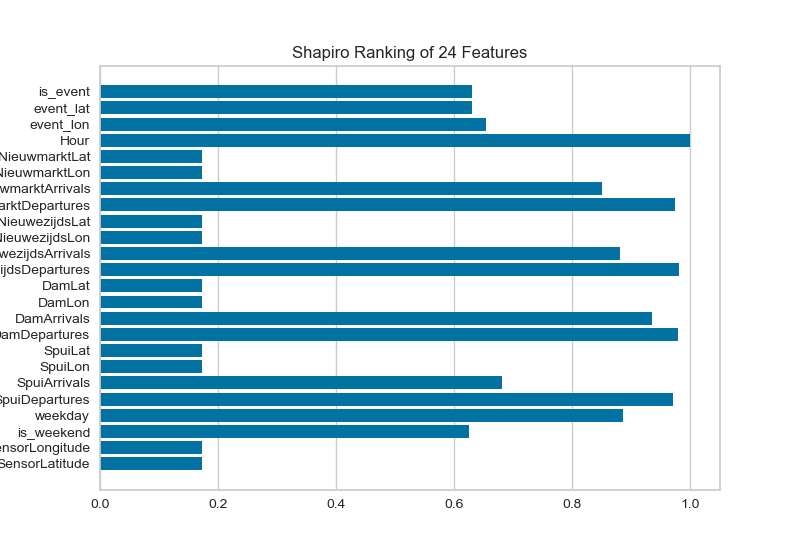

In [74]:
#Rank features - 1D
visualizer = Rank1D(algorithm='shapiro')

visualizer.fit(x, y)                # Fit the data to the visualizer
visualizer.transform(x)             # Transform the data
visualizer.poof() 

<IPython.core.display.Javascript object>


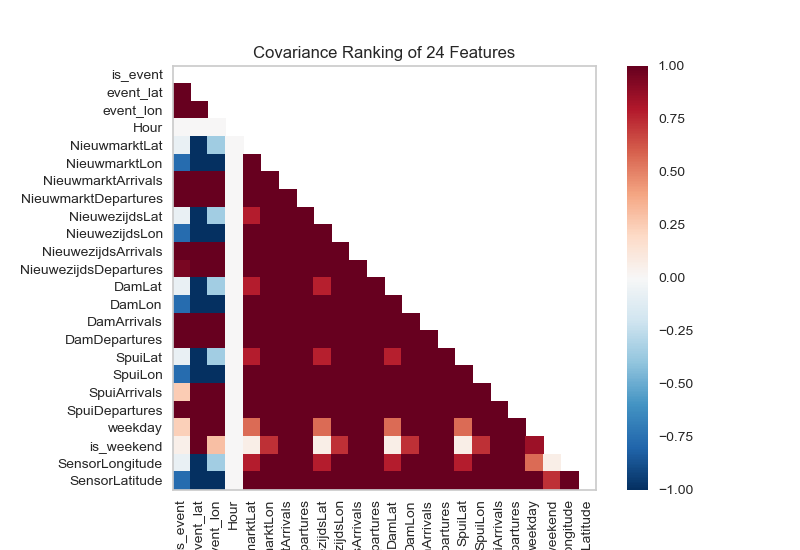

In [77]:
visualizer = Rank2D(algorithm='covariance')
visualizer.fit(x, y)                # Fit the data to the visualizer
visualizer.transform(x)             # Transform the data
visualizer.poof() 

In [19]:
#Train
x_train = train_df.drop(["CrowdednessCount"], axis=1)
y_train = train_df["CrowdednessCount"]

#Test
x_test = test_df.drop(["CrowdednessCount"], axis=1)
y_test = test_df["CrowdednessCount"]

feature_labels = train_df.columns.values

## Regression Models <a name="regModels"></a>

### Train/Test Split <a name="trainTestSplit"></a>
Split the dataset into training and test data, using a [function from Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

#### Train_Test_split Parameters
- *input*: 
    - *x*: data used to predict laballed data
        - Hour slot
        - Weekday (int)
        - Weekend (Binary)
    - *y*: laballed data
        - Number of rides (int)
- *test_size*: Proportion of total data used as test data, rest is training data
- *random_state*: Number used as seed by the *Random Number Generator* 

### Linear Regression <a name="regBaseModel"></a>
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)

In [20]:
#Give parameters model
reg_base = LinearRegression(n_jobs=5)

In [21]:
#Fit the model
reg_base.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=5, normalize=False)

In [22]:
reg_base_score = reg_base.score(x_test, y_test)

y_pred = reg_base.predict(x_test)
reg_mse = mean_squared_error(y_pred, y_test)

print("R^2 Score: ", reg_base_score)
print("MSE: ", reg_mse)
print("RMSE: ", np.sqrt(reg_mse))

R^2 Score:  0.3901533323836406
MSE:  243773.30336914436
RMSE:  493.7340411285659


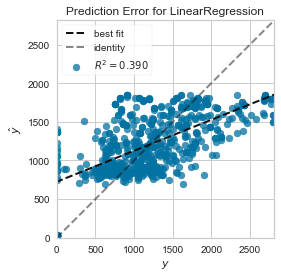

In [23]:
visualizer = PredictionError(reg_base)
visualizer.fit(x_train, y_train)  # Fit the training data to the visualizer
visualizer.score(x_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof() 

### Random Forrest Regressor <a name="regRFGModel"></a>
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

Parameters
- *N-Estimators*: Number of trees in the model
- *criterion*: loss function
- *n_jobs*: The number of jobs to run in parallel for both fit and predict
- *random_state*: random_state is the seed used by the random number generator
- *bootstrap*: Whether bootstrap samples are used when building trees

In [24]:
#Set parameters model
reg_rfg = RandomForestRegressor(n_estimators=500, criterion="mse", n_jobs=100, random_state=42, bootstrap=True)

In [25]:
#fit the model
reg_rfg.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=100,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [26]:
#Score the model
reg_rfg_score = reg_rfg.score(x_test, y_test)

#Test
y_pred = reg_rfg.predict(x_test)
reg_rfg_mse = mean_squared_error(y_pred, y_test)

print("R^2 Score: ", reg_rfg_score)
print("MSE Test: ", reg_rfg_mse)
print("RMSE Test: ", np.sqrt(reg_rfg_mse))

R^2 Score:  0.6068830908199396
MSE Test:  157140.16760254986
RMSE Test:  396.4090912208622


In [27]:
#Feature importance
importance = reg_rfg.feature_importances_
feature_indexes_by_importance = importance.argsort()
feature_indexes_by_importance = feature_indexes_by_importance[-5:]
for index in feature_indexes_by_importance:
    print('{}-{:.2f}%'.format(feature_labels[index], (importance[index] *100.0)))

NieuwezijdsDepartures-8.18%
DamDepartures-8.46%
NieuwmarktDepartures-12.76%
is_weekend-16.49%
weekday-19.20%


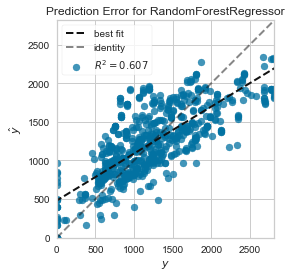

In [28]:
visualizer = PredictionError(reg_rfg)
visualizer.fit(x_train, y_train)  # Fit the training data to the visualizer
visualizer.score(x_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof() 

### Gradient Boosting Regressor <a name="regGBRModel"></a>
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor)

Parameters
- *Loss*: Loss function
- *Learning_rate*: Learning rate shrinks the contribution of each tree by learning_rate
- *n_estimators*: The number of boosting stages to perform
- *Criterion*: The function to measure the quality of a split
- *n_iter_no_change*: used to decide if early stopping will be used to terminate training when validation score is not improving
- *validation_fraction*: The proportion of training data to set aside as validation set for early stopping

In [29]:
reg_gbr = GradientBoostingRegressor(loss="ls", learning_rate=0.05, n_estimators=300, criterion="friedman_mse", 
                                    random_state=42, n_iter_no_change=20, validation_fraction=0.1)

In [30]:
reg_gbr.fit(x_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=300, n_iter_no_change=20, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [31]:
reg_gbr_score = reg_gbr.score(x_test, y_test)

#Training
y_pred = reg_gbr.predict(x_test)
reg_gbr_mse = mean_squared_error(y_pred, y_test)

print("R^2 Score: ", reg_gbr_score)
print("MSE Test: ", reg_gbr_mse)
print("RMSE Test: ", np.sqrt(reg_gbr_mse))

R^2 Score:  0.4882595912575671
MSE Test:  204557.40193549037
RMSE Test:  452.28022501043574


In [32]:
#Feature importance
importance = reg_gbr.feature_importances_
feature_indexes_by_importance = importance.argsort()
feature_indexes_by_importance = feature_indexes_by_importance[-5:]
for index in feature_indexes_by_importance:
    print('{}-{:.2f}%'.format(feature_labels[index], (importance[index] *100.0)))

NieuwmarktDepartures-9.98%
DamDepartures-11.55%
NieuwezijdsDepartures-12.99%
weekday-21.13%
is_weekend-25.24%


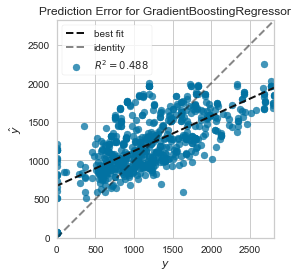

In [33]:
visualizer = PredictionError(reg_gbr)
visualizer.fit(x_train, y_train)  # Fit the training data to the visualizer
visualizer.score(x_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof() 

### Lasso <a name="regABRModel"></a>
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV)

In [34]:
reg_en = LassoCV(n_jobs=5, random_state=42, selection="random")

In [35]:
reg_en.fit(x_train, y_train)

D:\Programs\Anaconda\envs\Analytics\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=5, normalize=False, positive=False,
    precompute='auto', random_state=42, selection='random', tol=0.0001,
    verbose=False)

In [36]:
reg_en_score=reg_en.score(x_test, y_test)

y_pred = reg_en.predict(x_test)
reg_en_mse = mean_squared_error(y_pred, y_test)

print("R^2 Sore: ", reg_en_score)
print("MSE: ", reg_en_mse)
print("RMSE: ", np.sqrt(reg_en_mse))

R^2 Sore:  0.3809079640127543
MSE:  247468.94377896184
RMSE:  497.462504897567


D:\Programs\Anaconda\envs\Analytics\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


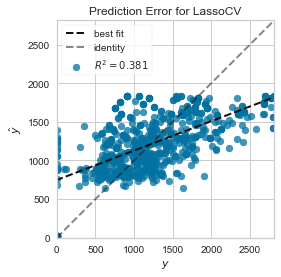

In [37]:
visualizer = PredictionError(reg_en)
visualizer.fit(x_train, y_train)  # Fit the training data to the visualizer
visualizer.score(x_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof() 

## Classification Models <a name="classification"></a>

### Change numerical labels to categorical labels <a name="classCatVar"></a>

In [103]:
#Check distribution crowdedness
counts = full["CrowdednessCount"].values

#Normal Distribute values, give mu and std
mu, std = norm.fit(counts)

In [104]:
clas_dict = full.to_dict("index")

In [105]:
for k, v in clas_dict.items():
    
    #Max crowdedness count for low level
    low_level = mu - std
    
    #Max crowdedness medium level
    high_level = mu + std
    
    #Assign class labels
    if v["CrowdednessCount"] < low_level:
        v["CrowdednessCount"] = 0
    elif v["CrowdednessCount"] > high_level:
        v["CrowdednessCount"] = 2
    else:
        v["CrowdednessCount"] = 1

In [106]:
clas_model_df = pd.DataFrame.from_dict(clas_dict, orient="index")

In [107]:
clas_model_df.head()

,Date,is_event,event_lat,event_lon,Hour,NieuwmarktCode,NieuwmarktLat,NieuwmarktLon,NieuwmarktArrivals,NieuwmarktDepartures,...,SpuiLat,SpuiLon,SpuiArrivals,SpuiDepartures,weekday,is_weekend,Sensor,SensorLongitude,SensorLatitude,CrowdednessCount
0,2018-06-28,1.0,52.372638,4.894106,0.0,NMT,4.901239,52.371942,44.0,143.0,...,4.889259,52.369097,13.0,40.0,4.0,0.0,GAWW-02,4.898903,52.373786,0
1,2018-06-04,1.0,52.372638,4.894106,0.0,NMT,4.901239,52.371942,44.0,143.0,...,4.889259,52.369097,13.0,40.0,4.0,0.0,GAWW-02,4.898903,52.373786,1
10,2018-03-24,1.0,52.358560,4.897830,0.0,NMT,4.901239,52.371942,83.0,225.0,...,4.889259,52.369097,0.0,70.0,6.0,1.0,GAWW-02,4.898903,52.373786,2
100,2019-02-16,1.0,52.372638,4.894106,0.0,NMT,4.901239,52.371942,42.0,67.0,...,4.889259,52.369097,0.0,0.0,5.0,1.0,GAWW-02,4.898903,52.373786,1
1000,2018-06-24,0.0,0.000000,0.000000,0.0,NMT,4.901239,52.371942,43.0,124.0,...,4.889259,52.369097,0.0,0.0,0.0,0.0,GAWW-02,4.898903,52.373786,1


In [108]:
train_df = clas_model_df[clas_model_df["Date"].isin(train_set)].drop(columns=["Date","NieuwmarktCode", 
                                                            "NieuwezijdsCode", "DamCode", "SpuiCode", "Sensor"])

test_df = clas_model_df[clas_model_df["Date"].isin(test_set)].drop(columns=["Date","NieuwmarktCode", 
                                                            "NieuwezijdsCode", "DamCode", "SpuiCode", "Sensor"])
full_df = clas_model_df.drop(columns=["Date","NieuwmarktCode", 
                                                            "NieuwezijdsCode", "DamCode", "SpuiCode", "Sensor"])

In [109]:
x = full_df.drop(["CrowdednessCount"], axis=1)
y = full_df["CrowdednessCount"]

<IPython.core.display.Javascript object>


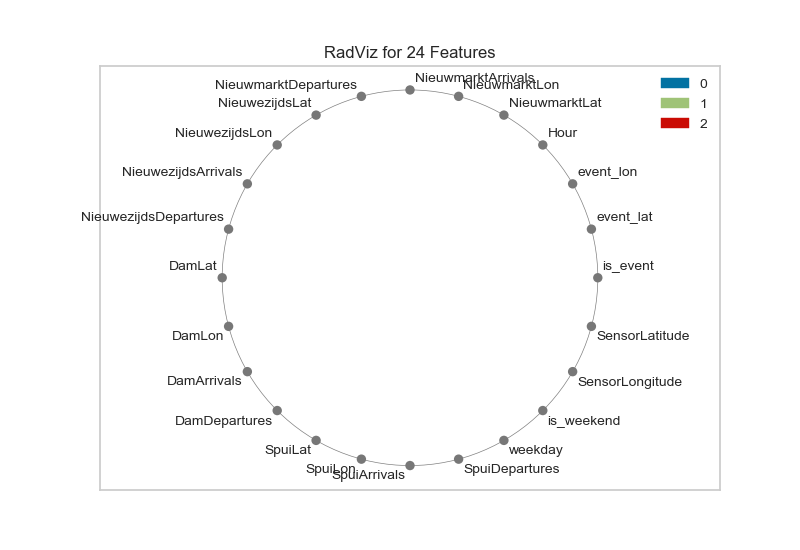

In [110]:
visualizer = RadViz()

visualizer.fit(x, y)      # Fit the data to the visualizer
visualizer.transform(x)   # Transform the data
visualizer.poof() 

In [44]:
#Train
x_train = train_df.drop(["CrowdednessCount"], axis=1)
y_train = train_df["CrowdednessCount"]

#Test
x_test = test_df.drop(["CrowdednessCount"], axis=1)
y_test = test_df["CrowdednessCount"]

feature_labels = train_df.columns.values

In [45]:
classes = ["Low", "Normal", "High"]

### Baseline <a name="classBaseModel"></a>
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html#sklearn.dummy.DummyClassifier)

Parameters
- *strategy*: "stratified” - generates predictions by respecting the training set’s class distribution.

In [46]:
clas_bas = DummyClassifier(strategy="stratified", random_state=42)

In [47]:
clas_bas.fit(x_train, y_train)

DummyClassifier(constant=None, random_state=42, strategy='stratified')

In [48]:
y_pred = clas_bas.predict(x_test)

print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy Score:  0.5953125
              precision    recall  f1-score   support

           0       0.22      0.23      0.22        82
           1       0.75      0.74      0.74       469
           2       0.17      0.17      0.17        89

   micro avg       0.60      0.60      0.60       640
   macro avg       0.38      0.38      0.38       640
weighted avg       0.60      0.60      0.60       640



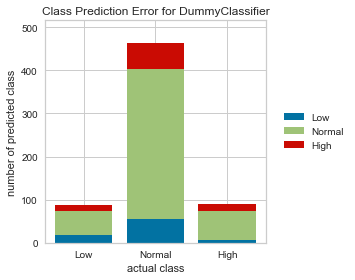

In [49]:
visualizer = ClassPredictionError(
    clas_bas, classes=classes
)

visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
g = visualizer.poof()

### Random Forrest Classifier <a name="classRFCModel"></a>
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)

In [50]:
clas_rfc = RandomForestClassifier(n_estimators=300, criterion="entropy", n_jobs=20, random_state=42, 
                                  class_weight="balanced")

In [51]:
clas_rfc.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=20, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [52]:
y_pred = clas_rfc.predict(x_test)

print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy Score:  0.75625
              precision    recall  f1-score   support

           0       0.66      0.95      0.78        82
           1       0.97      0.69      0.81       469
           2       0.43      0.92      0.59        89

   micro avg       0.76      0.76      0.76       640
   macro avg       0.69      0.85      0.73       640
weighted avg       0.86      0.76      0.77       640



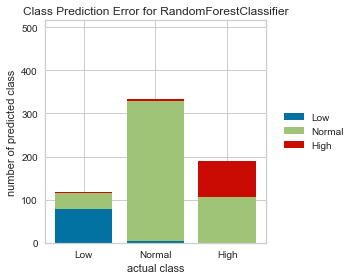

In [53]:
visualizer = ClassPredictionError(
    clas_rfc, classes=classes
)

visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
g = visualizer.poof()

### Gradient Boosting Classifier <a name="classGBCModel"></a>
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier)

In [54]:
clas_gbc = GradientBoostingClassifier(learning_rate=0.05, n_estimators=300, random_state=42, n_iter_no_change=20, 
                                     validation_fraction=0.1)

In [55]:
clas_gbc.fit(x_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              n_iter_no_change=20, presort='auto', random_state=42,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [56]:
y_pred = clas_gbc.predict(x_test)

print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy Score:  0.7953125
              precision    recall  f1-score   support

           0       0.97      0.44      0.61        82
           1       0.79      0.97      0.87       469
           2       0.59      0.18      0.28        89

   micro avg       0.80      0.80      0.80       640
   macro avg       0.79      0.53      0.59       640
weighted avg       0.79      0.80      0.76       640



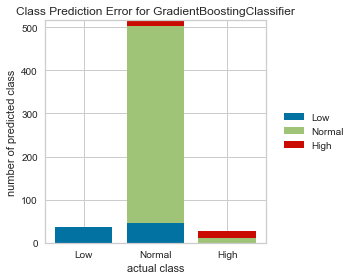

In [57]:
visualizer = ClassPredictionError(
    clas_gbc, classes=classes
)

visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
g = visualizer.poof()

### SGD Classifier  <a name="classSGDModel"></a>
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier)

In [58]:
reg_sgd = SGDClassifier(n_jobs=50, random_state=42)

In [59]:
reg_sgd.fit(x_train, y_train)

D:\Programs\Anaconda\envs\Analytics\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=50, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [60]:
y_pred = reg_sgd.predict(x_test)

print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy Score:  0.7328125
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        82
           1       0.73      1.00      0.85       469
           2       0.00      0.00      0.00        89

   micro avg       0.73      0.73      0.73       640
   macro avg       0.24      0.33      0.28       640
weighted avg       0.54      0.73      0.62       640



D:\Programs\Anaconda\envs\Analytics\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


D:\Programs\Anaconda\envs\Analytics\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


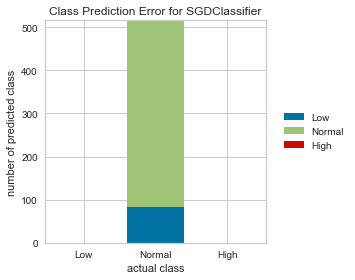

In [61]:
visualizer = ClassPredictionError(
    reg_sgd, classes=classes
)

visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
g = visualizer.poof()

### Voting Classifier <a name="classVCModel"></a>
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier)

This classifier combines the classifications of the [Random Forrest Classification](#classRFCModel) and [Gradient Boosting Classification](#classGBCModel) by classifying each instance with the one of the classes given by the models. 

In [62]:
#List estimator models
estimators = [("rfc", clas_rfc), ("gbc", clas_gbc)]

clas_vc = VotingClassifier(estimators=estimators, voting="soft", n_jobs=20,weights=[1, 2])

In [63]:
clas_vc.fit(x_train, y_train)

VotingClassifier(estimators=[('rfc', RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=20, voting='soft', weights=[1, 2])

In [64]:
y_pred = clas_vc.predict(x_test)

print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy Score:  0.80625
              precision    recall  f1-score   support

           0       0.94      0.57      0.71        82
           1       0.82      0.94      0.88       469
           2       0.53      0.30      0.39        89

   micro avg       0.81      0.81      0.81       640
   macro avg       0.76      0.61      0.66       640
weighted avg       0.79      0.81      0.79       640

